<a href="https://colab.research.google.com/github/MD2001/Pytorch_Bignnier/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

02. Neural Network classification with PyTorch
Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).
Book version of this notebook https://www.learnpytorch.io/02_pytorch_classification/

All other resources - https://github.com/mrdbourke/pytorch-deep-learning

Stuck? Ask a question https://github.com/mrdbourke/pytorch-deep-learning/
discussions

In [ ]:
import sklearn

#Data

In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X,Y =make_circles(n_samples,
                  noise=0.03,
                  random_state=42)

print(f"first five element from X : \n{X[:5]}")
print(f"first five element from Y : \n{Y[:5]}")


first five element from X : 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first five element from Y : 
[1 1 1 1 0]


In [ ]:
# visualise data
import pandas as pd
circles = pd.DataFrame({
                          "X1" : X[:,0],
                          "X2" : X[:,1],
                          "labels"  : Y[:]
})
circles.head(10)

,X1,X2,labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


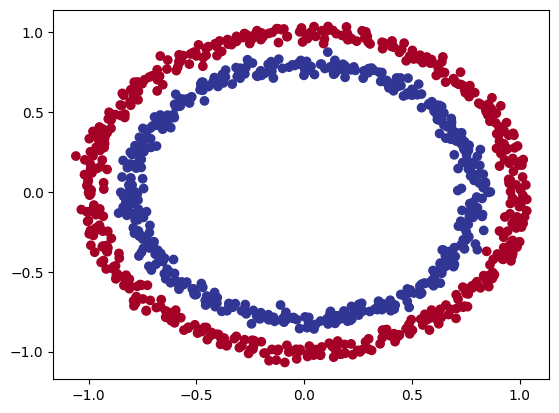

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=Y[:],
            cmap=plt.cm.RdYlBu)

after visualize data i assume it two circle and the input is coordinate to determine which do belonge to witch circle

In [ ]:
type(X) , X.dtype

(numpy.ndarray, dtype('float64'))

In [ ]:
import torch
#convert it to tensors
X=torch.from_numpy(X).type(torch.float)
Y=torch.from_numpy(Y).type(torch.float)

In [ ]:
type(X) , X.dtype

(torch.Tensor, torch.float32)

In [ ]:
print(f"this is one sample of X: {X[0]} and this its label Y :{Y[0]}")
print(f"this is the shape of X {X.shape} and this is the shape of Y {Y.shape}")

this is one sample of X: tensor([0.7542, 0.2315]) and this its label Y :1.0
this is the shape of X torch.Size([1000, 2]) and this is the shape of Y torch.Size([1000])


In [ ]:
#to split the data
from sklearn.model_selection import train_test_split

x_train , x_test , y_train, y_test =train_test_split(X,Y,test_size=0.2,random_state=42)


In [ ]:
len(x_train) , len(x_test) , len(y_train), len(y_test)

(800, 200, 800, 200)

##2. Building a model
Let's build a model to classify our blue and red dots.
To do do so, we want to:
1. Setup device agonistic code so our code code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [ ]:
#device digonistic code

device ="cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [ ]:
#create model

from torch import nn

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=8)
    self.layer_2=nn.Linear(in_features=8,out_features=1)
  def forwared(self, x :torch.Tensor)->torch.Tensor:
    return self.layer_2(self.layer_1(x))


### another way to do the same using nn.Sequebatial()

# class CircleModelV0(nn.Module):
#   def __init__(self):
#     super().__init__()

#     self.layerofTwo=nn.Sequential(
#         nn.Linear(in_features=2,out_features=8),
#         nn.Linear(in_features=8,out_features=1)
#     )


#   def forwared(self, x :torch.Tensor)->torch.Tensor:
#     return self.layerofTwo(x)

In [ ]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
x_train=x_train.to(device)
x_test=x_test.to(device)
y_train=y_train.to(device)
y_test=y_test.to(device)
x_train.device

device(type='cuda', index=0)

In [ ]:
## lets rewrite same code in less codeing
model_0=nn.Sequential(
    nn.Linear(in_features=2,out_features=8),
    nn.Linear(in_features=8,out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?
Again... this is problem specific.

For example for regression you might want MAE or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how *wrong* your models predictions |

In [ ]:
#set the loss function and the optimizer

lossfn = nn.BCEWithLogitsLoss() # has sigmoid activation function build with in it

optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [ ]:
# create function to chick for accurice
def accurcy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item() # we need it as item
  acc = (correct/len(y_true)) * 100
  return acc

## 3. Train model

To train the model we should go throw this steps:

1. Forwroed pass
2. Calculate the loss ( loss function )
3. Optimizer zero grad
4. loss backword ( backporbegation )
5. Optimizer step ( gredaint decient )

### going from prediction 'logits' (row output of nuren) -> prediction probilites -> predication labels

the output of modle is going to be raw **logits** .


* using activation function to turn logits to predication probilites .

**Ex:**
* `sigmoid()` for binare crossintropy classification.
* `softmax()` for multicalss classification.


By rounding the predication porbability or using `argmax()` function we turn it to predication labels (this is the goal we want)

In [ ]:
#get the row prediction output (logits)

y_logits = model_0(x_test[:5])
y_logits

tensor([[-0.9463],
        [-0.8918],
        [-0.9995],
        [-0.9316],
        [-0.8570]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
# turn logits to prediction porbabilites

y_pred_prop = torch.sigmoid(y_logits)
y_pred_prop

tensor([[0.2796],
        [0.2907],
        [0.2690],
        [0.2826],
        [0.2980]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
#turn prediction probabilites to prediction labels

y_labels=torch.round(y_pred_prop)
y_labels.squeeze()

tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
# do it all agine in one line

y_labels_predication = torch.round(torch.sigmoid(model_0(x_test[:5])))

#to make sure it same
print(torch.eq(y_labels,y_labels_predication).squeeze())

#full output
y_labels_predication.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
### trainging loop

epochs = 1000

# loop
for epoch in range(epochs):
  #prepaer model to training
  model_0.train()

  #1. forwared data
  # use only for calculate the loss function | we do not add sigmoid layer to it cause the loss function we use has one and it more numircal stable with it
  y_logits=model_0(x_train).squeeze()

  y_pred= torch.round(torch.sigmoid(y_logits))


  #2.calculate the loss function
  loss = lossfn(y_logits,y_train)

  #we can use the accuercy function we made

  acc=accurcy_fn(y_pred=y_pred,y_true=y_train)

  #3.zero grade
  optimizer.zero_grad()

  #4.loss backword

  loss.backward()

  #5.optimizer step

  optimizer.step()

  ##testing
  model_0.eval()
  with torch.inference_mode():
    #forwared pass
    y_test_logits=model_0(x_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))

    #claculate the loss

    loss_test = lossfn(y_test_logits,y_test)
    acc_test = accurcy_fn(y_true=y_test, y_pred=y_test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} , Acc: {acc:.2f}% | Testloss: {loss_test:.5f} , Testacc {acc_test:.2f}%  ")



Epoch: 0 | Loss: 0.79230 , Acc: 50.00% | Testloss: 0.77921 , Testacc 50.00%  
Epoch: 100 | Loss: 0.69300 , Acc: 50.75% | Testloss: 0.69470 , Testacc 47.00%  
Epoch: 200 | Loss: 0.69298 , Acc: 51.38% | Testloss: 0.69460 , Testacc 46.00%  
Epoch: 300 | Loss: 0.69298 , Acc: 51.50% | Testloss: 0.69464 , Testacc 45.00%  
Epoch: 400 | Loss: 0.69298 , Acc: 51.25% | Testloss: 0.69466 , Testacc 45.00%  
Epoch: 500 | Loss: 0.69298 , Acc: 51.12% | Testloss: 0.69467 , Testacc 45.50%  
Epoch: 600 | Loss: 0.69298 , Acc: 51.12% | Testloss: 0.69468 , Testacc 46.00%  
Epoch: 700 | Loss: 0.69298 , Acc: 51.00% | Testloss: 0.69468 , Testacc 46.00%  
Epoch: 800 | Loss: 0.69298 , Acc: 51.00% | Testloss: 0.69468 , Testacc 46.00%  
Epoch: 900 | Loss: 0.69298 , Acc: 51.00% | Testloss: 0.69468 , Testacc 46.00%  


In [ ]:
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
  print("helper_functions.py is alerady existe skip download")
else:
  print("Download helper_functions.py")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

Download helper_functions.py


In [ ]:
from helper_functions import plot_predictions , plot_decision_boundary

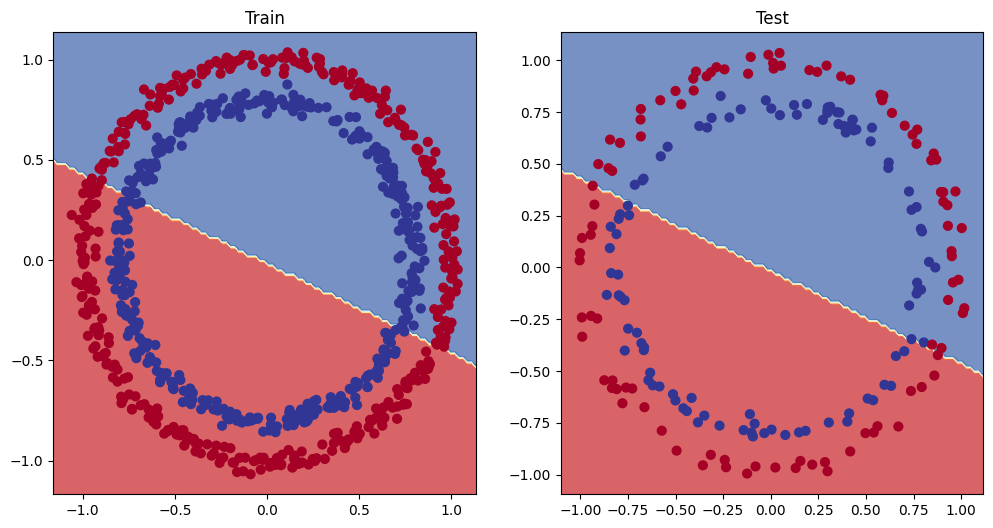

In [ ]:
#Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test)

##solving this issues

we cab solve this problem from model precpective throgh:
1. adding more hidden layers
2. adding more hidden unite
3. change type of layer `use activations functions`
4. change learning rate
5. change the loss function
6. fit for more longer ("take time in learning")

In [ ]:
class CircleModelV1 (nn.Module):
  def __init__(self):
    super().__init__()
    layer_1= nn.Linear(in_features=2,out_features=10),
    layer_2= nn.Linear(in_features=10,out_features=10),
    layer_3= nn.Linear(in_features=10,out_features=1)
  def forward(self,x):
    # z=self.layer_1(x)
    # z=self.layer_2(z)
    # z=self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))

In [ ]:
model_1 = CircleModelV1()
model_1.to(device)

CircleModelV1()

In [ ]:
##create data set to test

wight= 0.7
bias= 0.3

start = 0
end = 1
step = 0.01

x_data=torch.arange(start,end,step).unsqueeze(dim=1)
y_predict= (wight*x_data) + bias
print(f"the lenght of data is {len(x_data)} sample")
print(f"some example of data and its values ")
x_data[:5],y_predict[:5]


the lenght of data is 100 sample
some example of data and its values 


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
## split data to test and training
split =(int) (0.8 *len(x_data))
x_train_reg , x_test_reg = x_data[:split],x_data[split:]
y_train_reg , y_test_reg = y_predict[:split],y_predict[split:]

#checking

len(x_test_reg),len(x_train_reg),len(y_test_reg),len(y_train_reg)

(20, 80, 20, 80)

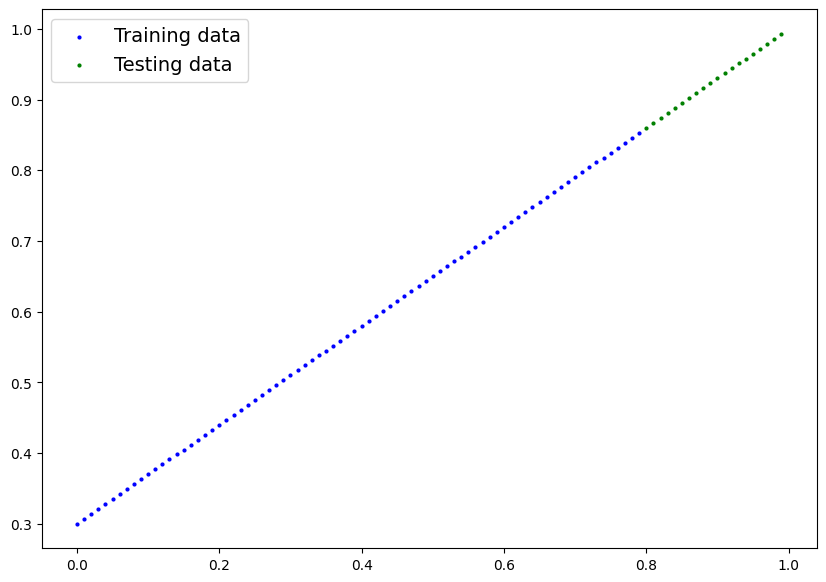

In [ ]:
## visulaise the data
plot_predictions(x_train_reg,y_train_reg,x_test_reg,y_test_reg)

In [ ]:
## adjust the input to fit this data set
model_2 =nn.Sequential(
    nn.Linear(1,10),
    nn.Linear(10,10),
    nn.Linear(10,1),
)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
## loss and optimaizer

loss_fn_reg = nn.L1Loss()

optimizer_reg=torch.optim.SGD(model_2.parameters(),lr=0.01)

In [ ]:
## training loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# send data and model to gpu
model_2= model_2.to(device)
x_train_reg,x_test_reg =x_train_reg.to(device),x_test_reg.to(device)
y_train_reg,y_test_reg = y_train_reg.to(device),y_test_reg.to(device)

#get reade for taining
model_2.train()

epochs = 10000
epooch = epochs//10

for epoch in range(epochs):
  predict = model_2(x_train_reg)
  loss_reg=loss_fn_reg(predict,y_train_reg)
  optimizer_reg.zero_grad()
  loss_reg.backward()
  optimizer_reg.step()

  model_2.eval()
  with torch.inference_mode():
    predict_test = model_2(x_test_reg)
    loss_test_reg = loss_fn_reg(predict_test,y_test_reg)
  if epoch % epooch == 0:
    print(f"Epoch: {epoch} | loss : {loss_reg:0.5f} | loss_test {loss_test_reg:0.5f}")


Epoch: 0 | loss : 0.21037 | loss_test 0.57334
Epoch: 1000 | loss : 0.01733 | loss_test 0.00391
Epoch: 2000 | loss : 0.01468 | loss_test 0.00353
Epoch: 3000 | loss : 0.01371 | loss_test 0.00309
Epoch: 4000 | loss : 0.01239 | loss_test 0.00214
Epoch: 5000 | loss : 0.01126 | loss_test 0.00198
Epoch: 6000 | loss : 0.01072 | loss_test 0.00191
Epoch: 7000 | loss : 0.01000 | loss_test 0.00152
Epoch: 8000 | loss : 0.00984 | loss_test 0.00190
Epoch: 9000 | loss : 0.00976 | loss_test 0.00199


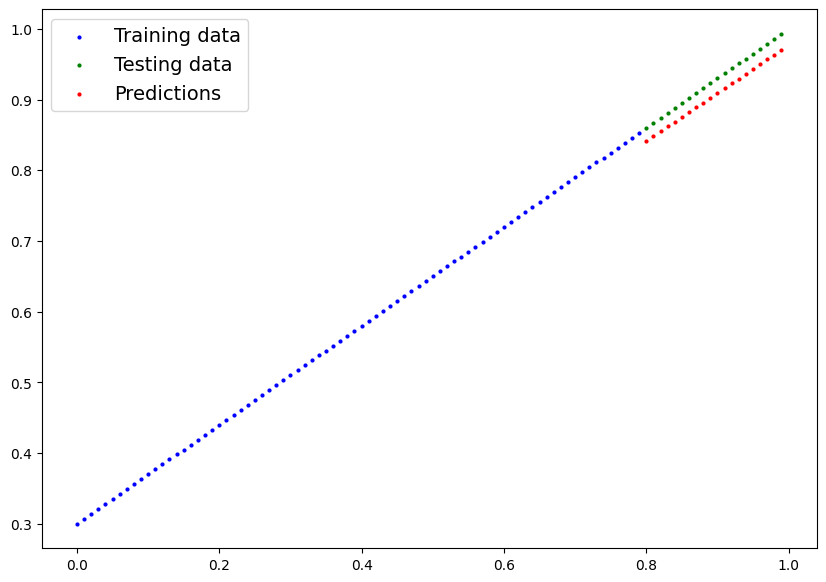

In [ ]:
## visulaise the data

model_2.eval()
with torch.inference_mode():
  y_pre=model_2(x_test_reg)

plot_predictions(x_train_reg.to("cpu"),y_train_reg.to("cpu"),x_test_reg.to("cpu"),y_test_reg.to("cpu"),predictions=y_pre.to("cpu"))

## now we know for sure that our data is learining but not with our data we want

#the missing peice is nonlinearty

In [ ]:
class  CircleModelV2 (nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1=nn.Linear(in_features=2,out_features=10)
    self.layer2=nn.Linear(in_features=10,out_features=10)
    self.layer3=nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
#set the loss function and the optimizer

lossfn = nn.BCEWithLogitsLoss() # has sigmoid activation function build with in it

optimizer = torch.optim.SGD(params=model_3.parameters(),lr=0.01)

In [ ]:
### training loop
epochs=2000

model_3.to(device)
x_train,y_train = x_train.to(device),y_train.to(device)
x_test,y_test = x_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_3.train()

  y_logits_nl = model_3(x_train).squeeze()
  y_predict= torch.round(torch.sigmoid(y_logits_nl))

  loss= lossfn(y_logits_nl,y_train)
  acc = accurcy_fn(y_train,y_predict)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

    ##testing
  model_3.eval()
  with torch.inference_mode():
    #forwared pass
    y_test_logits=model_3(x_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))

    #claculate the loss

    loss_test = lossfn(y_test_logits,y_test)
    acc_test = accurcy_fn(y_true=y_test, y_pred=y_test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} , Acc: {acc:.2f}% | Testloss: {loss_test:.5f} , Testacc {acc_test:.2f}%  ")

Epoch: 0 | Loss: 0.69295 , Acc: 50.00% | Testloss: 0.69325 , Testacc 50.00%  
Epoch: 100 | Loss: 0.69248 , Acc: 50.38% | Testloss: 0.69264 , Testacc 50.00%  
Epoch: 200 | Loss: 0.69225 , Acc: 59.00% | Testloss: 0.69233 , Testacc 56.00%  
Epoch: 300 | Loss: 0.69209 , Acc: 70.12% | Testloss: 0.69214 , Testacc 67.00%  
Epoch: 400 | Loss: 0.69195 , Acc: 68.38% | Testloss: 0.69197 , Testacc 70.00%  
Epoch: 500 | Loss: 0.69181 , Acc: 58.50% | Testloss: 0.69179 , Testacc 62.00%  
Epoch: 600 | Loss: 0.69168 , Acc: 54.00% | Testloss: 0.69163 , Testacc 56.00%  
Epoch: 700 | Loss: 0.69155 , Acc: 53.25% | Testloss: 0.69148 , Testacc 53.00%  
Epoch: 800 | Loss: 0.69141 , Acc: 52.62% | Testloss: 0.69133 , Testacc 53.00%  
Epoch: 900 | Loss: 0.69128 , Acc: 52.75% | Testloss: 0.69118 , Testacc 53.00%  
Epoch: 1000 | Loss: 0.69115 , Acc: 53.00% | Testloss: 0.69104 , Testacc 52.50%  
Epoch: 1100 | Loss: 0.69103 , Acc: 52.88% | Testloss: 0.69089 , Testacc 53.00%  
Epoch: 1200 | Loss: 0.69090 , Acc: 53.12

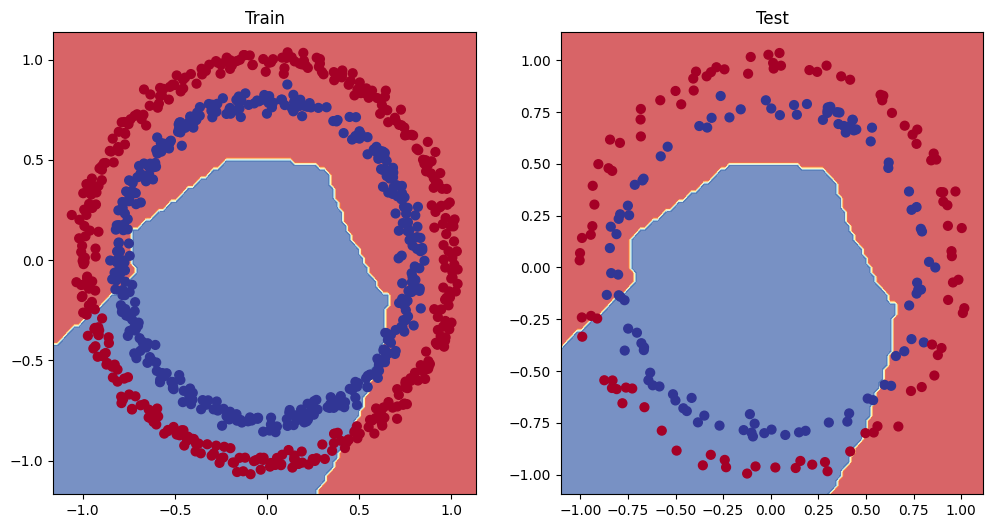

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, x_test, y_test)
#26000 epochs

In [7]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# hyper parameters

NUM_OF_CLASSES= 6
NUM_OF_FEATUERS = 2
SEED_NUM = 42

#create data
x_blob ,y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_OF_FEATUERS,
                            centers=NUM_OF_CLASSES,
                            cluster_std=1.5,
                            random_state=SEED_NUM)

type(x_blob)

numpy.ndarray

In [8]:
##since the x_blob is just numpy array and we use tensors in py torch we need to change it
## make device digonistice statement also

In [9]:
device ="cuda" if torch.cuda.is_available else "cpu"

x_blob=torch.from_numpy(x_blob).type(torch.float32).to(device)
y_blob=torch.from_numpy(y_blob).type(torch.float32).to(device)

In [10]:
### now make train and test data

In [16]:
x_blob_traing , x_blob_testing , y_blob_traing , y_blob_testing =  train_test_split(x_blob,y_blob,test_size=0.2,random_state=SEED_NUM)
x_blob_traing[:5],y_blob_traing[:5]

(tensor([[ 0.2671,  1.4585],
         [-8.8228,  5.3558],
         [-6.5671, -9.9427],
         [ 6.1493,  1.1078],
         [-8.1628, 11.9641]], device='cuda:0'),
 tensor([4., 3., 2., 1., 5.], device='cuda:0'))